In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%pip install tableone
import tableone
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from google.colab import files
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
import warnings
# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

%load_ext google.colab.data_table
# change this to change the right project
%env GOOGLE_CLOUD_PROJECT = dukedatathon2024

  Using cached tableone-0.8.0-py3-none-any.whl (33 kB)
Authenticated
env: GOOGLE_CLOUD_PROJECT=dukedatathon2024


In [2]:
complete_df = pd.read_csv('complete_df.csv')

In [3]:
# Replace 'M' with 1 and 'F' with 0 in the 'gender' column
complete_df['gender'] = complete_df['gender'].replace({'M': 1, 'F': 0})

# Specify columns to convert to float
X_cols = ['anchor_age', 'gender', 'anchor_year',
       'sepsis3', 'procedure_freq',
       'icu_stay_num', 'admission_num', 'in2first_days', 'first2out_days',
       'in2last_days', 'last2out_days', 'first2last_days', 'death',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose',
       'initial_crp', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp', 'readiness']

int_cols = ['anchor_age' ,'gender','anchor_year','procedure_freq','icu_stay_num','admission_num','in2first_days','first2out_days','in2last_days','last2out_days','first2last_days','death']
bol_col = ['sepsis3','initial_vasopressor_needed_within_24hr','initial_ventilation_within_6hr','initial_fio2_above_60_within_6hr','off_vasopressors','last_fio2_above_60','off_ventilation','readiness']

# Convert specified columns to float using astype()
complete_df[int_cols] = complete_df[int_cols].astype(float)
complete_df[bol_col] = complete_df[bol_col].astype(int)
complete_df = complete_df.fillna(np.nan)


In [4]:
# check for variable correlation & feature selection

#find design matrix for linear regression model using 'rating' as response variable
y_vif, X_vif = dmatrices('los ~ anchor_age+gender+anchor_year+sepsis3+procedure_freq+icu_stay_num+admission_num+in2first_days+first2out_days+in2last_days+last2out_days+first2last_days+death+initial_vasopressor_needed_within_24hr+initial_ventilation_within_6hr+initial_fio2_above_60_within_6hr+initial_sodium+initial_wbc+initial_creatinine+initial_ph+initial_lactate+initial_baseexcess+initial_glucose+initial_crp+off_vasopressors+last_fio2_above_60+off_ventilation+last_ph+last_lactate+last_baseexcess+last_hemoglobin+last_creatinine+last_sodium+last_glucose+last_wbc+last_crp+readiness', data=complete_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['variable'] = X_vif.columns

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [5]:
# check for variable correlation & feature selection

#find design matrix for linear regression model using 'rating' as response variable
y_vif, X_vif = dmatrices('los ~ anchor_age+gender+anchor_year+sepsis3+procedure_freq+icu_stay_num+admission_num+in2first_days+first2out_days+in2last_days+last2out_days+first2last_days+death+initial_vasopressor_needed_within_24hr+initial_ventilation_within_6hr+initial_fio2_above_60_within_6hr+initial_sodium+initial_wbc+initial_creatinine+initial_ph+initial_lactate+initial_baseexcess+initial_glucose+initial_crp+off_vasopressors+last_fio2_above_60+off_ventilation+last_ph+last_lactate+last_baseexcess+last_hemoglobin+last_creatinine+last_sodium+last_glucose+last_wbc+last_crp+readiness', data=complete_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['variable'] = X_vif.columns

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [6]:
# Filter the DataFrame to get variable names with VIF less than 5
selected_variables = vif.loc[vif['VIF'].fillna(0) < 5, 'variable'].tolist()
selected_variables.remove('Intercept')

In [7]:
# split train & test
X = complete_df[selected_variables].fillna(0)
y = complete_df['los']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

#################### Prediction Outcome on Test Data ####################
Mean Squared Error (MSE): 75.4636
R-squared (R2): 0.1787
#################### Feature Importance Summary ####################
sepsis3: 0.00000
procedure_freq: -1.06534
icu_stay_num: -0.02533
admission_num: 0.94038
first2last_days: 2.59312
death: 0.54007
initial_ventilation_within_6hr: 1.47623
initial_creatinine: 1.06036
off_vasopressors: 0.00000
last_fio2_above_60: 0.44346
off_ventilation: -0.00000
last_sodium: 0.83740
readiness: -0.79981


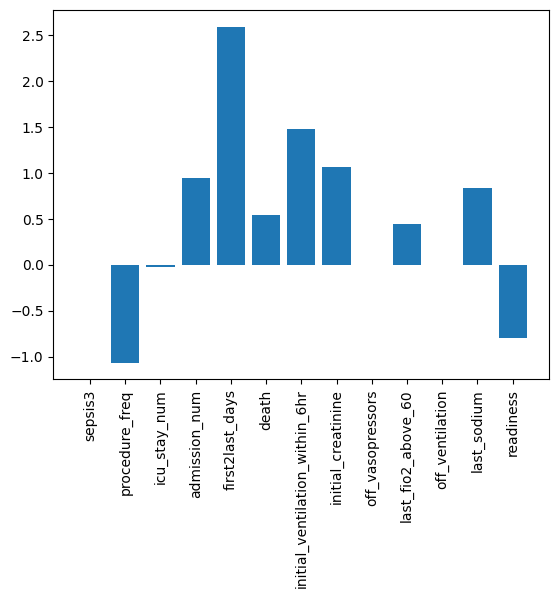

In [8]:
# normalize & perform linear regression & print regression output

scaler = StandardScaler()

# Fit and transform the scaler on x_train
X_train_scaled = scaler.fit_transform(X_train)

# Transform X_test using the same scaler
X_test_scaled = scaler.transform(X_test)

# fit linear model
model = LinearRegression()

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'''{'#'*20} Prediction Outcome on Test Data {'#'*20}''')
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# summarize feature importance
print(f'''{'#'*20} Feature Importance Summary {'#'*20}''')
importance = model.coef_
for i,v in enumerate(importance):
  print(f'{X_train.columns[i]}: {v:.5f}')
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xticks(np.arange(0, len(X_train.columns), step=1), labels = X_train.columns, rotation=90)
pyplot.show()
